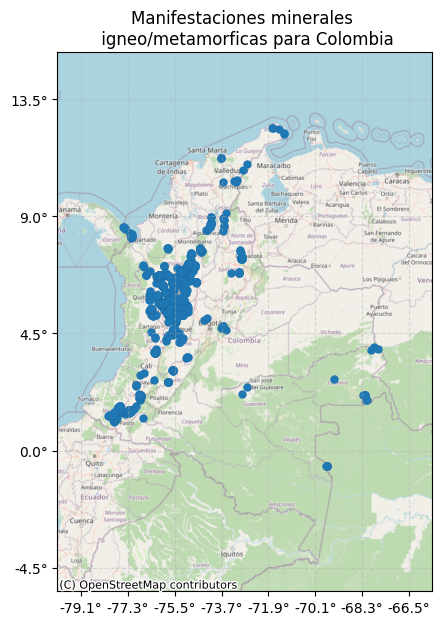

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter
# Ruta al archivo shapefile (.shp)
ruta = r"C:/Git_SCA/AGE/Depositos"  # Usa r"" para evitar problemas con backslashes
# Cargar el shapefile
gdf = gpd.read_file(ruta)
# Reproyectar al sistema de Web Mercator (requerido por contextily)
gdf = gdf.to_crs(epsg=3857)
# Función para convertir de Web Mercator a grados decimales (aproximado)
def mercator_to_lon(x, _):
    return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _):
    return f"{y * 180 / 20037508.34:.1f}°"
# Crear el gráfico
fig, ax = plt.subplots(figsize=(7, 7))
# Graficar el shapefile con color según 'Z'
gdf.plot(
    ax=ax,
    linewidth=0.01,
    edgecolor='black'
)
# Centrar el mapa en Colombia (coordenadas en Web Mercator)
ax.set_xlim([-8900000, -7300000])
ax.set_ylim([-600000, 1700000])
# Formatear los ejes con coordenadas bonitas
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
# Añadir líneas de grilla suaves
ax.grid(True, which='major', linestyle='--', alpha=0.4)
# Añadir el mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
# Título y visualización
plt.title("Manifestaciones minerales \n igneo/metamorficas para Colombia")
#ax.set_axis_off()  # Si prefieres mostrar solo el mapa sin ejes, descomenta esta línea
plt.show()

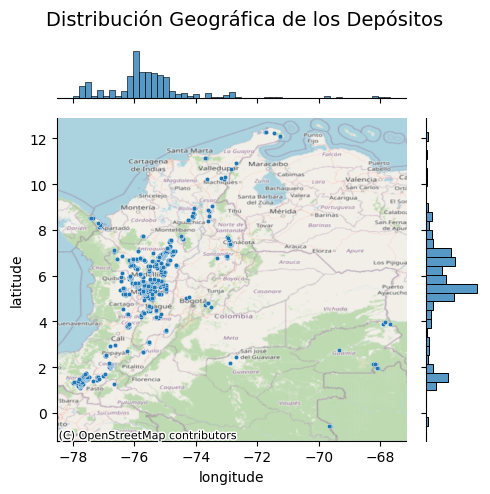

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx

# Reproyectar a EPSG:4326 para lat/lon
gdf_latlon = gdf.to_crs(epsg=4326)
gdf['Longitude'] = gdf_latlon.geometry.x
gdf['Latitude'] = gdf_latlon.geometry.y

# Crear jointplot
joint_axes = sns.jointplot(
    x='longitude', y='latitude',
    data=gdf, s=10,
    height=5,
    space=0
)

# Añadir mapa base confiable
ctx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=ctx.providers.OpenStreetMap.Mapnik
)

# Añadir título
joint_axes.fig.suptitle("Distribución Geográfica de los Depósitos", fontsize=14)
joint_axes.fig.tight_layout()
joint_axes.fig.subplots_adjust(top=0.90)

plt.show()


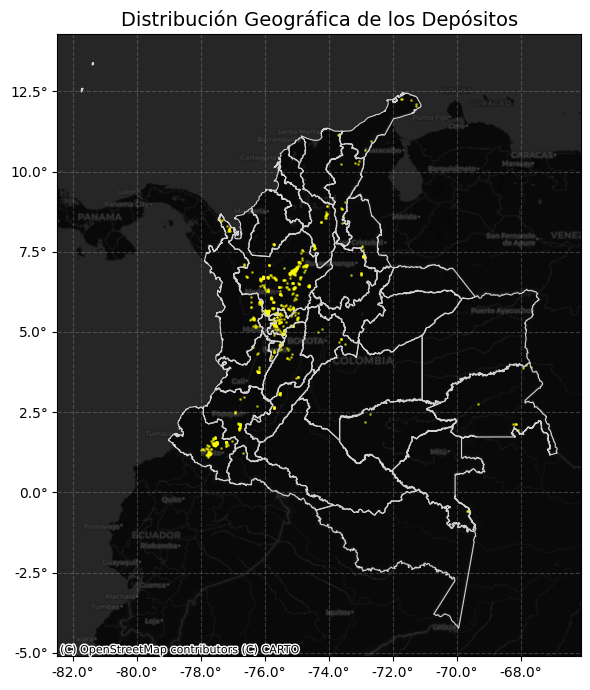

In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# === 1. Reproyectar puntos a EPSG:4326 y extraer coordenadas ===
gdf_latlon = gdf.to_crs(epsg=4326)
gdf['Longitude'] = gdf_latlon.geometry.x
gdf['Latitude'] = gdf_latlon.geometry.y

# === 2. Cargar límites administrativos ===
areas_path = r"C:/Git_SCA/AGE/departamentos"
areas = gpd.read_file(areas_path).to_crs(epsg=4326)

# === 3. Crear figura y eje ===
fig, ax = plt.subplots(figsize=(7, 7))

# === 4. Graficar puntos
ax.scatter(gdf['Longitude'], gdf['Latitude'], s=1, c="xkcd:bright yellow", alpha=0.5)

# === 5. Añadir límites administrativos con color tenue
areas.plot(ax=ax, facecolor="none", edgecolor="lightgray", linewidth=0.8)

# === 6. Mapa base oscuro
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.DarkMatter)

# === 7. Ejes en grados decimales
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.1f}°"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}°"))

# === 8. Personalización
ax.grid(True, linestyle="--", alpha=0.3)
ax.set_title("Distribución Geográfica de los Depósitos", fontsize=14)

plt.tight_layout()
plt.show()


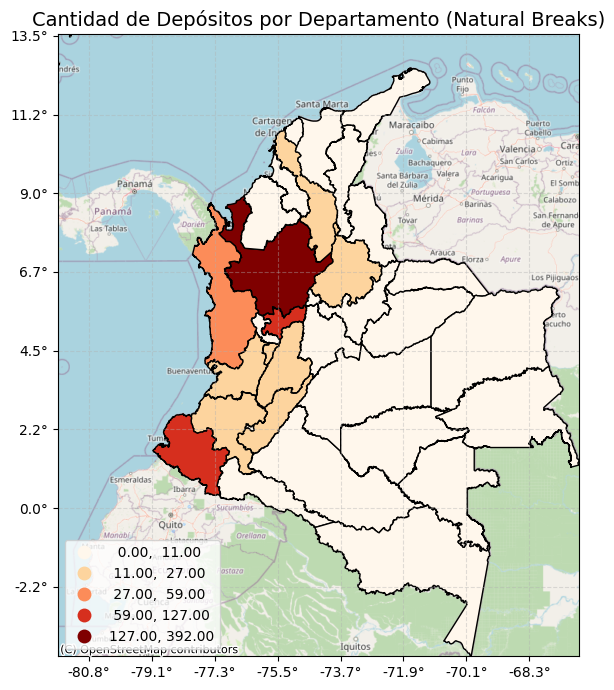

In [94]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# === 1. Cargar puntos y municipios ===
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
departamentos = gpd.read_file(r"C:/Git_SCA/AGE/departamentos").to_crs(epsg=3857)

# === 2. Join espacial: contar puntos por municipio ===
join = gpd.sjoin(gdf, departamentos, predicate='within')
conteo = join.groupby('DeNombre').size().reset_index(name='depositos')

# === 3. Unir conteo al GeoDataFrame de municipios ===
departamentos = departamentos.merge(conteo, on='DeNombre', how='left')
departamentos['depositos'] = departamentos['depositos'].fillna(0)

# === 4. Graficar ===
fig, ax = plt.subplots(figsize=(7, 7))
departamentos.plot(
    column='depositos',
    cmap='OrRd',
    scheme='natural_breaks',
    k=5,
    legend=True,
    legend_kwds={'loc': 'lower left'},
    edgecolor='black', linestyle="-",
    ax=ax
)

# === 5. Añadir ejes y mapa base ===
minx, miny, maxx, maxy = departamentos.total_bounds
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 180 / 20037508.34:.1f}°"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y * 180 / 20037508.34:.1f}°"))
ax.grid(True, linestyle="--", alpha=0.4)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs='EPSG:3857')

plt.title("Cantidad de Depósitos por Departamento (Natural Breaks)", fontsize=14)
plt.tight_layout()
plt.show()


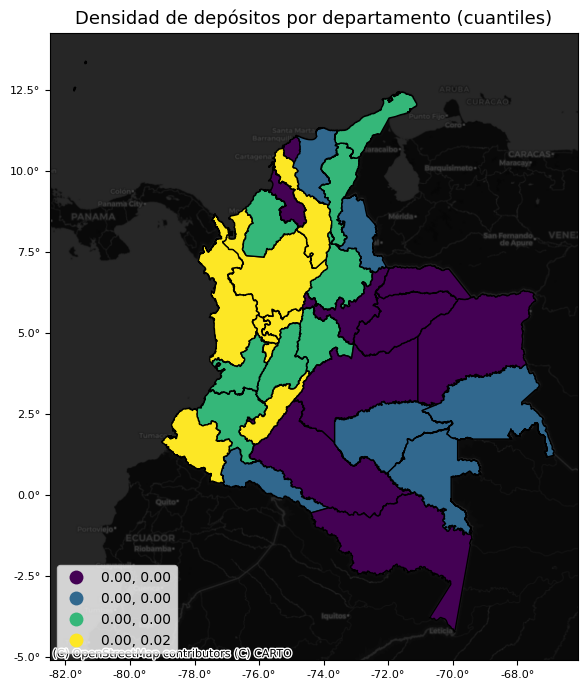

In [103]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# === 1. Cargar shapefiles ===
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Depositos").to_crs(epsg=4326)
departamentos = gpd.read_file(r"C:/Git_SCA/AGE/departamentos").to_crs(epsg=4326)

# === 2. Spatial join: contar depósitos por departamento ===
joined = gpd.sjoin(gdf, departamentos, predicate='within')
conteo = joined.groupby('DeNombre').size().reset_index(name='conteo_depositos')

# === 3. Calcular densidad: depósitos por área en km² ===
departamentos['area_km2'] = departamentos.geometry.to_crs(epsg=3857).area / 1e6
departamentos = departamentos.merge(conteo, on='DeNombre', how='left')
departamentos['conteo_depositos'] = departamentos['conteo_depositos'].fillna(0)
departamentos['densidad'] = departamentos['conteo_depositos'] / departamentos['area_km2']

# === 4. Mapa choropleth ===
fig, ax = plt.subplots(1, figsize=(7, 7))
departamentos.plot(
    column='densidad',
    scheme='quantiles',
    k=4,
    ax=ax,
    legend=True,
    legend_kwds={"loc": 'lower left'},
    edgecolor='black'
)

# === 5. Formatear ejes con coordenadas en grados ===
def format_lon(x, _): return f"{x:.1f}°"
def format_lat(y, _): return f"{y:.1f}°"
ax.xaxis.set_major_formatter(FuncFormatter(format_lon))
ax.yaxis.set_major_formatter(FuncFormatter(format_lat))
ax.tick_params(axis='both', which='major', labelsize=8)

# === 6. Título y fondo ===
ax.set_title("Densidad de depósitos por departamento (cuantiles)", fontsize=13)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.DarkMatter)

# === 7. Mostrar ===
plt.tight_layout()
plt.show()


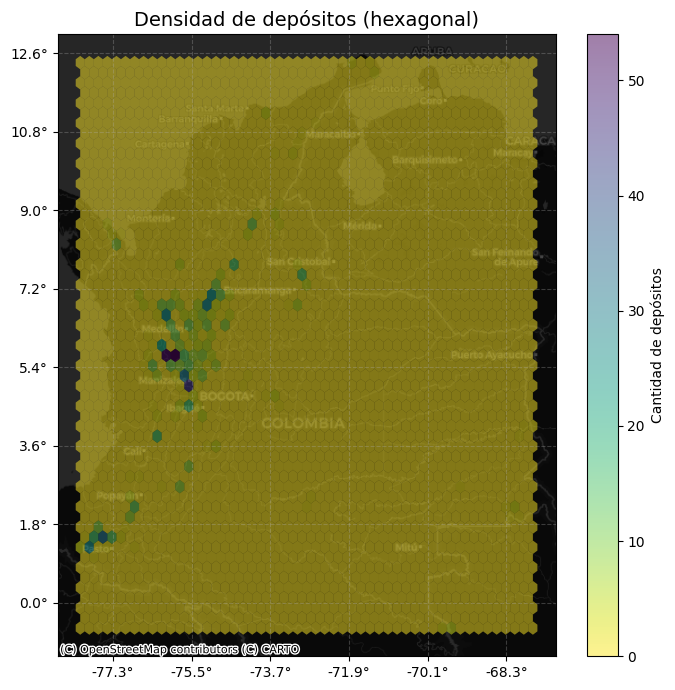

In [104]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.ticker import FuncFormatter

# === 1. Cargar depósitos y reproyectar a EPSG:3857 ===
gdf = gpd.read_file(r"C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
gdf['x'] = gdf.geometry.x
gdf['y'] = gdf.geometry.y

# === 2. Crear figura ===
fig, ax = plt.subplots(1, figsize=(7, 7))

# === 3. Hexbin ===
hb = ax.hexbin(
    gdf['x'], gdf['y'],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap='viridis_r'
)

# === 4. Añadir mapa base ===
ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter, crs=gdf.crs)

# === 5. Coordenadas en grados decimales (EPSG:4326) ===
def mercator_to_lon(x, _): return f"{x * 180 / 20037508.34:.1f}°"
def mercator_to_lat(y, _): return f"{y * 180 / 20037508.34:.1f}°"
ax.xaxis.set_major_formatter(FuncFormatter(mercator_to_lon))
ax.yaxis.set_major_formatter(FuncFormatter(mercator_to_lat))
ax.grid(True, linestyle="--", alpha=0.3)

# === 6. Leyenda y título ===
plt.colorbar(hb, ax=ax, label='Cantidad de depósitos')
ax.set_title("Densidad de depósitos (hexagonal)", fontsize=14)
plt.tight_layout()
plt.show()


In [106]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
from scipy.stats import gaussian_kde
from rasterio.transform import from_origin
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
from matplotlib.ticker import FuncFormatter
import os

# === 1. Cargar depósitos y área de Colombia ===
gdf = gpd.read_file("C:/Git_SCA/AGE/Depositos").to_crs(epsg=3857)
colombia = gpd.read_file("C:/Git_SCA/AGE/Area_Col").to_crs(epsg=3857)

# === 2. Extraer coordenadas ===
x = gdf.geometry.x.values
y = gdf.geometry.y.values
xy = np.vstack([x, y])

# === 3. KDE ajustado ===
kde = gaussian_kde(xy, bw_method=0.1)

# === 4. Crear grilla regular ===
minx, miny, maxx, maxy = colombia.total_bounds
res = 500  # Alta resolución
xgrid = np.arange(minx, maxx, res)
ygrid = np.arange(miny, maxy, res)
xx, yy = np.meshgrid(xgrid, ygrid)
coords = np.vstack([xx.ravel(), yy.ravel()])
zz = kde(coords).reshape(xx.shape)

# === 5. Guardar raster ===
transform = from_origin(minx, maxy, res, res)
temp_raster_path = "kde_temp.tif"
with rasterio.open(
    temp_raster_path, 'w',
    driver='GTiff',
    height=zz.shape[0],
    width=zz.shape[1],
    count=1,
    dtype='float32',
    crs='EPSG:3857',
    transform=transform
) as dst:
    dst.write(zz.astype('float32'), 1)

# === 6. Recortar al contorno de Colombia ===
with rasterio.open(temp_raster_path) as src:
    out_image, out_transform = mask(src, colombia.geometry.map(mapping), crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# === 7. Visualizar resultado ===
fig, ax = plt.subplots(figsize=(7, 7))
extent = [
    out_transform[2],
    out_transform[2] + out_transform[0] * out_image.shape[2],
    out_transform[5] + out_transform[4] * out_image.shape[1],
    out_transform[5]
]
img = ax.imshow(out_image[0], extent=extent, origin='upper', cmap='plasma')
colombia.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Coordenadas en grados
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 180 / 20037508.34:.1f}°"))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y * 180 / 20037508.34:.1f}°"))
ax.grid(True, linestyle="--", alpha=0.4)

# Mapa base
ctx.add_basemap(ax, crs='EPSG:3857', source=ctx.providers.CartoDB.Positron)

# Título y leyenda
plt.colorbar(img, ax=ax, label="Densidad KDE")
ax.set_title("Estimación de Densidad (KDE) de Depósitos", fontsize=14)
plt.tight_layout()
plt.show()

# === 8. Eliminar archivo temporal ===
os.remove(temp_raster_path)
